<br><p style="font-family: Arial; font-size:3.75em;color:purple; font-style:bold">
Clustify<br>
    

Music is a driving force for me. I listen to it in the morning while making breakfast, during my commute to work and before I go to bed. Since Im usually to busy to make my own playlist, Spotify's "Daily Mixes" are perfect for me. They take my favorite songs, group similar ones together and create cohesive playlists for me.

I wanted to see if I could create my own system to do something similar. Thus, Clustify was born.

Clustify takes your top 100 most played tracks and creates four unique playlist using the K-Means clustering algorithm. This notebook will walk you step by step through the process.

In [1]:
%matplotlib inline

import os
import json
import spotipy
import numpy as np
import pandas as pd
import spotipy.util as util
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.cluster import KMeans

## Create your Spotify App

The first thing you have to do is create your Spotify app through the Spotify for Developers <a href='https://developer.spotify.com/'>site</a> . Once created you will have access to your Client ID, Client Secret and redirect URI.
    
Now that we have those we can setup a token that will allow use to login. 

The scope atribute tells the Spotify API what premissions we need. You can read more about them <a href='https://developer.spotify.com/documentation/general/guides/scopes/'> here</a>. For now all we need to do is read the users most played songs.

In [2]:
SPOTIPY_CLIENT_ID = '65aff1cf84fb4067a58a2c6c6a601e98'
SPOTIPY_CLIENT_SECRET = 'f721c25610d443b784d0911e8440ccfb'
SPOTIPY_REDIRECT_URI = 'https://www.google.com/'

username = 'DevTheWrightOne'
scope = 'user-top-read'

# Prompt for user premissions
token = util.prompt_for_user_token(username, scope, client_id = SPOTIPY_CLIENT_ID,
                           client_secret = SPOTIPY_CLIENT_SECRET,redirect_uri=SPOTIPY_REDIRECT_URI)

## Gathering Data

Now that we have sucessfully logged in we can create a Spotify object using the <a href='https://spotipy.readthedocs.io/en/latest/'> Spotipy Python library</a>.

The Spotify API only allows you to retrieve 50 songs at a time. You can also specify what time span you want to collect the songs from with the 'time_range' parameter. We are going to use 'short_term' which will give us the most played song from the past month.

In [3]:
# Create a spotify object
spotify = spotipy.Spotify(auth=token)

# Get currents user's top 50 songs.
results = spotify.current_user_top_tracks(offset=0, time_range='short_term', limit=50)

The results are returned to us in JSON format. Lets go ahead and display the top 50 songs along with the artist in a more readable format.

In [4]:
print('Top 50 Songs')
for i, item in enumerate(results['items']):
    print(i, item['name'], 'by', item['artists'][0]['name'])

Top 50 Songs
0 Smoke Session by Mozzy
1 IGOR'S THEME by Tyler, The Creator
2 Passionfruit by Drake
3 GRoCERIES by Chance the Rapper
4 I THINK by Tyler, The Creator
5 EARFQUAKE by Tyler, The Creator
6 Madiba Riddim by Drake
7 Jesus Is The One (I Got Depression) by Zack Fox
8 Ojuelegba by WizKid
9 The London (feat. J. Cole & Travis Scott) by Young Thug
10 Corners Of My Mind by Emotional Oranges
11 F What The Opp Said by Chief Keef
12 Come Closer (feat. Drake) by WizKid
13 Devil in California by Burna Boy
14 Mi Unruly by Popcaan
15 New Person, Same Old Mistakes by Tame Impala
16 RUNNING OUT OF TIME by Tyler, The Creator
17 Kontrol by Maleek Berry
18 Drais by Moneybagg Yo
19 NEW MAGIC WAND by Tyler, The Creator
20 Boshe Nlo by Burna Boy
21 London by Jeremih
22 Sound of Rain by Solange
23 Not Nice by PARTYNEXTDOOR
24 5200 by ScHoolboy Q
25 Hallelujah by Burna Boy
26 Just My Luck (feat. Sada Baby) by Mozzy
27 A BOY IS A GUN* by Tyler, The Creator
28 Feel the Same (feat. Lamii) by Toyin Ores


## Data Analytics
Now that we have the top 50 songs we can analysis them and create some cohesive playlists, but we can't do that with just song names. We need some type of features that provide us with information about the songs. Luckily, Spotify's '<a href='https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/'>get-audio-features</a>' API request will give us that information.

To get these features we have to use the song IDs which were provided to use in the last request. Lets go ahead and store them in there own list along with the song names and artist names.

In [5]:
# List containing song names
top_song_names = [item['name'] for item in results['items']]

# List containing artist names
top_song_artists = [item['artists'][0]['name'] for item in results['items']]

# List containing song IDs
top_song_ids = [item['uri'] for item in results['items']]

Now we can pass the song IDs to the audio_features method and retrieve the song feature for all 50 songs. They will come in JSON format, but to make things simpler we'll store them in a Pandas Dataframe and take a look at the features names.

In [6]:
# Using song ids get song features for all the songs
tracks_features = spotify.audio_features(top_song_ids)

# Create a dataframe containing all the songs and their features
top_50_songs = pd.read_json(json.dumps(tracks_features))

# View the features present in the DataFrame
print(top_50_songs.columns)

Index(['acousticness', 'analysis_url', 'danceability', 'duration_ms', 'energy',
       'id', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'track_href', 'type', 'uri',
       'valence'],
      dtype='object')


For the purposes of this notebook we will be using the energy and valence features.

<b>Energy</b> is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale.

<b>Valence</b> is a measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).

We will go ahead and get rid of the columns in the Dataframe we dont need and add the song names and artist names to the Dataframe.

In [7]:
# Get the features that we need (Energy and Valence)
columns = ['energy', 'valence', 'id']
top_50_songs = top_50_songs[columns]

# Add the song name and artist name to the DataFrame
top_50_songs['title'] = top_song_names
top_50_songs['artist'] = top_song_artists

# Rearrange columns
columns = ['title', 'artist', 'valence', 'energy', 'id']
top_50_songs = top_50_songs[columns]

# Veiw the Dataframe
top_50_songs

,title,artist,valence,energy,id
0,Smoke Session,Mozzy,0.1120,0.496,2sycbIpVfHRQrGMxEHvadq
1,IGOR'S THEME,"Tyler, The Creator",0.0648,0.672,51RN0kzWd7xeR4th5HsEtW
2,Passionfruit,Drake,0.3720,0.459,5mCPDVBb16L4XQwDdbRUpz
3,GRoCERIES,Chance the Rapper,0.7010,0.596,0yFvWTLs3iIwDbc91noXGT
4,I THINK,"Tyler, The Creator",0.4310,0.579,4f8Mh5wuWHOsfXtzjrJB3t
5,EARFQUAKE,"Tyler, The Creator",0.4130,0.498,5hVghJ4KaYES3BFUATCYn0
6,Madiba Riddim,Drake,0.3190,0.527,76gUmNLXGQVOsGhfcshkFP
7,Jesus Is The One (I Got Depression),Zack Fox,0.3270,0.446,1YR9iNGXtsbrd8deR9ULDD
8,Ojuelegba,WizKid,0.9010,0.748,6cTLhp8a39TClL2iqGpPVc
9,The London (feat. J. Cole & Travis Scott),Young Thug,0.1790,0.586,7DcvwMAiqKJQD1rrdfxSDx


### Graphing Our Data
Lets graph our data on a scatter plot to get an idea of how dispersed the songs are from each other. A songs valence will be measured along the x-axis and its energy will be measured along the y-axis.

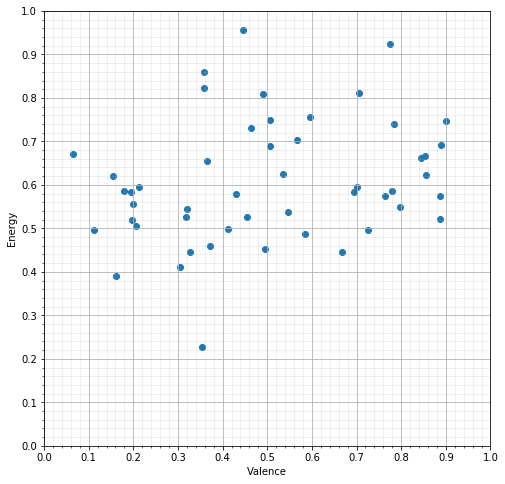

In [9]:
#Plot the songs
x = top_50_songs['valence']
y = top_50_songs['energy']

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(x, y)
ax.set_xlabel('Valence')
ax.set_ylabel('Energy')
ax.xaxis.set_major_locator(ticker.FixedLocator(np.arange(0,1.1, step=0.1)))
ax.yaxis.set_major_locator(ticker.FixedLocator(np.arange(0,1.1, step=0.1)))
ax.set_xlim(left=0, right=1.0)
ax.set_ylim(bottom=0, top=1.0)
plt.grid(b=True, which='major')
plt.minorticks_on()
plt.grid(b=True, which='minor', alpha=0.25)
plt.show()

## Modeling Our Data
We are going to use the K-Means clustering algorithm from the Scikit-learn library to model are data. We will be group our songs into 4 clusters based on their energy and valence features. Each one of these clusters will represent a playlist.

Before we being we need to prepare our data by moving it into a numpy array so that we can feed it into the model.

In [10]:
# Prepare data for K-Means clustering algorithm by putting data in a numpy array
data = np.array([[i,j] for i,j in zip(x,y)])

Lets go ahead and check that we have all 50 data points.

In [11]:
# Check that there is 50 pairs of data points.
print(data.shape)

(50, 2)


Now that the data is prepared lets go head and create our model, fit our data and plot the clusters.

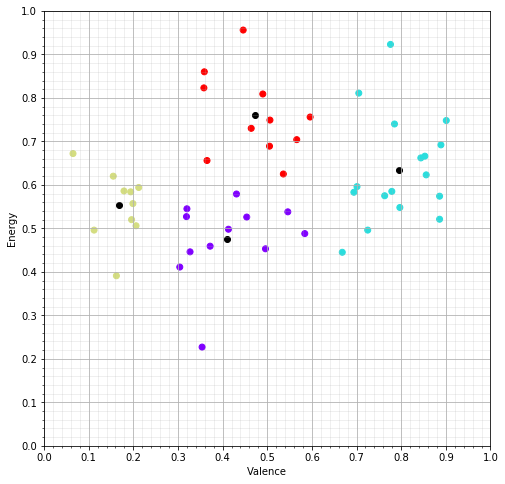

In [13]:
# Now we can use KMeans to cluster the songs togther using 4 centroids.
kmeans = KMeans(n_clusters=4)
kmeans.fit(data)

# Plot the clusters
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(data[:,0],data[:,1], c=kmeans.labels_, cmap='rainbow')
ax.scatter(kmeans.cluster_centers_[:,0] ,kmeans.cluster_centers_[:,1], color='black')  

ax.set_xlabel('Valence')
ax.set_ylabel('Energy')
ax.xaxis.set_major_locator(ticker.FixedLocator(np.arange(0,1.1, step=0.1)))
ax.yaxis.set_major_locator(ticker.FixedLocator(np.arange(0,1.1, step=0.1)))
ax.set_xlim(left=0, right=1.0)
ax.set_ylim(bottom=0, top=1.0)
plt.grid(b=True, which='major')
plt.minorticks_on()
plt.grid(b=True, which='minor', alpha=0.25)
plt.show()

We have successfuly grouped and labeled our top 50 songs into 4 unique playlist/clusters. Lets create a list containing the labels because we will need them later.

In [14]:
# Lets save the labels in a list.
playlist_labels = kmeans.labels_

## Predicting the next 50 songs
Now that we have a model of the data we can use it to predict which playlist a song belongs to. We will do this with the next 50 songs for the users top play tracks.

Lets collect the next 50 songs and store them with the rest for a total of 100 songs.

In [15]:
# Create new token and spotify object
token = util.prompt_for_user_token(username, scope, client_id = SPOTIPY_CLIENT_ID,
                           client_secret = SPOTIPY_CLIENT_SECRET,redirect_uri=SPOTIPY_REDIRECT_URI)

spotify = spotipy.Spotify(auth=token)

results = spotify.current_user_top_tracks(offset=49, time_range='short_term', limit=50)
    
top_song_names.extend([item['name'] for item in results['items']])
top_song_artists.extend([item['artists'][0]['name'] for item in results['items']])
top_song_ids.extend([item['uri'] for item in results['items']])

# Check that there are 100 songs in total.
print(len(top_song_names))

100


Now that we have the next 50 songs and their IDs we can get their features. We will then create a DataFrame containing all the information and feature for all 100 songs. 

In [16]:
# Get song features for all 100 songs.
tracks_features = spotify.audio_features(top_song_ids)

# Create a new DataFrame containing all 100 songs.
top_100_songs = pd.read_json(json.dumps(tracks_features))

# Get the features that we need (Energy and Valence)
columns = ['energy', 'valence', 'id']
top_100_songs = top_100_songs[columns]

# Add the song name and artist name to the DataFrame
top_100_songs['title'] = top_song_names
top_100_songs['artist'] = top_song_artists

# Rearrange columns
columns = ['title', 'artist', 'valence', 'energy', 'id']
top_100_songs = top_100_songs[columns]
top_100_songs

,title,artist,valence,energy,id
0,Smoke Session,Mozzy,0.1120,0.496,2sycbIpVfHRQrGMxEHvadq
1,IGOR'S THEME,"Tyler, The Creator",0.0648,0.672,51RN0kzWd7xeR4th5HsEtW
2,Passionfruit,Drake,0.3720,0.459,5mCPDVBb16L4XQwDdbRUpz
3,GRoCERIES,Chance the Rapper,0.7010,0.596,0yFvWTLs3iIwDbc91noXGT
4,I THINK,"Tyler, The Creator",0.4310,0.579,4f8Mh5wuWHOsfXtzjrJB3t
5,EARFQUAKE,"Tyler, The Creator",0.4130,0.498,5hVghJ4KaYES3BFUATCYn0
6,Madiba Riddim,Drake,0.3190,0.527,76gUmNLXGQVOsGhfcshkFP
7,Jesus Is The One (I Got Depression),Zack Fox,0.3270,0.446,1YR9iNGXtsbrd8deR9ULDD
8,Ojuelegba,WizKid,0.9010,0.748,6cTLhp8a39TClL2iqGpPVc
9,The London (feat. J. Cole & Travis Scott),Young Thug,0.1790,0.586,7DcvwMAiqKJQD1rrdfxSDx


We already have a labels for the first 50 songs, now we can use the model to predict the labels for the next 50 songs. We will add the labels to the 'playlist_labels' list.

In [17]:
data = np.array([[i,j] for i,j in zip(top_100_songs['valence'], top_100_songs['energy'])])

predictions = kmeans.predict(data[50:100])
playlist_labels = np.append(playlist_labels, predictions)

# Check that there are 100 label in total.
print(len(playlist_labels))

100


Now we can add the labels to the DataFrame.

In [18]:
top_100_songs['playlist'] = playlist_labels

top_100_songs

,title,artist,valence,energy,id,playlist
0,Smoke Session,Mozzy,0.1120,0.496,2sycbIpVfHRQrGMxEHvadq,2
1,IGOR'S THEME,"Tyler, The Creator",0.0648,0.672,51RN0kzWd7xeR4th5HsEtW,2
2,Passionfruit,Drake,0.3720,0.459,5mCPDVBb16L4XQwDdbRUpz,0
3,GRoCERIES,Chance the Rapper,0.7010,0.596,0yFvWTLs3iIwDbc91noXGT,1
4,I THINK,"Tyler, The Creator",0.4310,0.579,4f8Mh5wuWHOsfXtzjrJB3t,0
5,EARFQUAKE,"Tyler, The Creator",0.4130,0.498,5hVghJ4KaYES3BFUATCYn0,0
6,Madiba Riddim,Drake,0.3190,0.527,76gUmNLXGQVOsGhfcshkFP,0
7,Jesus Is The One (I Got Depression),Zack Fox,0.3270,0.446,1YR9iNGXtsbrd8deR9ULDD,0
8,Ojuelegba,WizKid,0.9010,0.748,6cTLhp8a39TClL2iqGpPVc,1
9,The London (feat. J. Cole & Travis Scott),Young Thug,0.1790,0.586,7DcvwMAiqKJQD1rrdfxSDx,2


## Creating playlists and adding songs
Great we successfully labeled our top 100 songs in 4 unique playlist. Now all we need to do is create the playlist and add the songs in the out Spotify library. 


In [19]:
# Scope needed to create playlists and add songs to them.
scope = 'playlist-modify-public'

# Create a new token and spotify object.
token = util.prompt_for_user_token(username, scope, client_id = SPOTIPY_CLIENT_ID,
                           client_secret = SPOTIPY_CLIENT_SECRET,redirect_uri=SPOTIPY_REDIRECT_URI)

spotify = spotipy.Spotify(auth=token)

# Create the playlist and add the songs.
for i in range(1,5):
    # Get the songs the belong in playlist 'i'
    filter = top_100_songs['playlist'] == i-1
    stage = top_100_songs[filter]
    track_ids = stage['id']
    
    # Create the playlist
    name = "Clustify Daily Mix {}".format(i)
    playlist = spotify.user_playlist_create(user=username, name=name, public=True)
    playlist_id = playlist['id']
    
    # Add songs to the playlist
    results = spotify.user_playlist_add_tracks(user=username, playlist_id=playlist_id, tracks=track_ids)



            User authentication requires interaction with your
            web browser. Once you enter your credentials and
            give authorization, you will be redirected to
            a url.  Paste that url you were directed to to
            complete the authorization.

        
Opened https://accounts.spotify.com/authorize?client_id=65aff1cf84fb4067a58a2c6c6a601e98&response_type=code&redirect_uri=https%3A%2F%2Fwww.google.com%2F&scope=playlist-modify-public in your browser


Enter the URL you were redirected to: https://www.google.com/?code=AQBV39VSAfQYvqhx-Cf9J83c0RBbsVH8M4F2FNG_0SH80FjnCmovxO0AZKcIsCpybs3NrIYiHl9v0EY8B1iUhDHfr9i01-8rMlMJejp_sBFyzADGM-DiK4uKgf_H6FEtL_JExIhKH3xeWjtVztZzPZ88z-t2Z9EKTVP7SYUeC6aO9Mlfa2XC3OC0D4VkUunVllCgMDrFyunPbNGkMfeJA3p0z-CSkVA




## Done!!
We have successfully created our own Spotify Daily Mixes